In [1]:
from cycloneFilter import cycloneFilter
from solid import *
from solid.utils import *
import viewscad
import math

In [2]:
def extrudePipeline(position1, position2, radius1, radius2, maxCurvature):
    '''
    pathplans an extruded pipeline (cylinder) from [x1,y1,z1] to [x2, y2, z2]
    
    Paramters:
        position1: [x,y,z] of starting point where cylinder will be centered
        position2: [x,y,z] of ending point where cylinder will be centered
        radius1: radius of pipeline starting point.
        radius2: radius of pipeline ending point.
        maxCurvature: maximum amount of curvature allowed in pipeline extrusion to 
                      prevent folding and pinching therefore clogging.
    '''
    #TODO: this requires a kernel stride from previous layer to next due to unequal count.
    #possibly implement this later after curtain, check clog rate empirically.
    #NOTE: radius should be set to intake/outlet cross sectional area
    #TODO: use holes to allow overlap of pipelines at position1
    #dont need to use hull() method?
    #just need to describe a line from position1 to position2 with given curvature.
    
    return None #prototype cell

In [3]:
def crossSectionalArea(*params):
    '''
    calculate the cross sectional area of the given cycloneFilter.
    
    Parameters:
        cycloneFilterParams: parameters that will define a cycloneFilter
    Returns:
        area as an integer
    '''
    #POSITIONAL LEGEND:
    # initParams=[intakeSlitHeight=10, intakeSlitWidth=2,
    #     intakeLeft=True, vortexSearcherDepth=5, collectorDepth=75,
    #     cylinderRadius=10, cylinderHeight=15, wallWidth=0.05]
    
    #length times width is easiest calculation since inlet = outlet
    
    return params[0] * params[1]

In [13]:
def cycloneArray(init_params, delta_params, length, width, height):
    '''
    build sequential/parallel array of cyclone filters in a cartesian grid pattern.
    starts by fitting width with init_params cycloneFilter objects, then alters geometry by delta_params
    and adds the equivalent airflow solution of the new cycloneFilter objects to the described rectangular prism.
    Stops when the rectangular prism is filled. through each sequence of delta_params filters the total cross sectional
    area of intakes/outlets is kept constant.
    
    Parameters:
            init_params: list of cycloneFilter positional parameters to start from
            delta_params: list of values that will change each respective positional init_params
            length: array size containing sequential filters
            width: array size containing parallel filters 
            height: array height for filters
    '''
    #TODO: assert each cyclone doesnt cause pressure differentials due to cylinder_radius
    #      being smaller than intake/outlet_radius
    #TODO: assert initial cylinder can fit in the first place (init cylinderRadius)
    #
    # NOTE: this is a square increase in number of filters. consider having residual connections
    # such that one pipeline across a row can 'jump' to the next row and freeze parameter deltas
    # to achieve sufficient cross sectional area. This allows a row to span more than one
    # carriage return. if sequence limit is reached before cross sectional area equivalence can
    # be established, discard that entry and end (unfinished fill since next row would cause pressure
    # differential.
    #
    # currently solve sequences across carriage returns, then add partitioning logic in the loop.
    # immediate goal should be to solve cross sectional area between sequences. Simply draw a curtain
    # on each row for now.
    #TODO: curtains cause low pressure regions due to square loss across large volume. this increases clog chance greatly
    #      compared to high pressure pipelines minimized for cross section of intake/outlet where constant high velocity fields
    #      keep particle friction dynamic
    #DEVELOPMENT:
    #1. carriage return multi row sequences
    #2. curtain on each row
    #3. curtain on each sequence with pipelining input and exhaust
    
    #POSITIONAL LEGEND:
    # initParams=[intakeSlitHeight=10, intakeSlitWidth=2,
    #     intakeLeft=True, vortexSearcherDepth=5, collectorDepth=75,
    #     cylinderRadius=10, cylinderHeight=15, wallWidth=0.05]
    #TODO: set poisitional parameters as dictionary for keyword reference and unpack with ** operator
    #TODO: move this into iterator, can be used to calculate if a extra filter can be added.
    params = init_params
    curPosition = [0,0]
    array = None
    xDistance, yDistance = 0, 0
    print(params)
   

    #TODO: only call deltas if sum of cross-sectional area has been met
    #deiterate cross-sectional area in this loop.
    arrayBuffer = [] #holds a cell of filters
    areaSolution = 0 #static total sum of cross sectional area needed in parallel 
                     #for sequence pressure equivalence (not considering pressure loss in filter)
    areaBuffer = 0 #buffer for deiterating areaSolution per row in a sequence
    
    while True: #sequential loop
        print('in the loop')
        
        #set parameters based on given equation matrix, wallWidth is only float.
        if areaBuffer <= 0 and areaSolution != 0:
            print('\n iterating filter parameters.. \n')
            params = [y(x) for x,y in zip(params, delta_params)]
            paramsBuffer = [int(x) for x in params[:-1]]
            paramsBuffer.append(params[len(params)-1])
            params = paramsBuffer
            print(params)
            areaBuffer = areaSolution
            
            print('appending filters')
            #dump the buffer into the solution object
            for cyclone in arrayBuffer:
                if array is None:
                    array = cyclone
                else:
                    array+=cyclone
        
        #keep z dimension the same throughout array by mutating collector depth
        #TODO: this should be extracted and integrated into collectorDepth parameter
        if params[6] + params[4] < height:
            params[4] += height - (params[6] + params[4])
        elif params[6] + params[4] > height:
            params[4] -= (params[6] + params[4]) - height
        
        curPosition[1] += yDistance #y position
        curPosition[0] = 0 #carriage return x axis
        
        #distance between each filter
        #TODO: if these are same name them the same.
        xDistance = 2*params[5] + params[7]
        yDistance = xDistance 
        
        #TODO: try to find best parallelFilters for the closest approximation of areaBuffer. 
        #      error on low pressure rather than high pressure
        parallelFilters = math.ceil(width/xDistance)
        print('sequence contains {} parallel filters'.format(parallelFilters))
        
        #initialize areaSolution.
        if areaSolution == 0:
            #first filter sequence sets areaSolution (currently just one row is initial cell)
            areaSolution = parallelFilters*crossSectionalArea(*params)
            areaBuffer = areaSolution
            print('initialized areaSolution: {} areaBuffer: {}'.format(areaSolution, areaBuffer))
            
        if curPosition[1] > length:
            print('EOL: filter sequence')
            print('dumping {} cyclone filters from last sequence clipping'.format(len(arrayBuffer)))
            arrayBuffer.clear()
            break
                    
        #add filters
        print('parallelFilters {} mod 2 is {}'.format(parallelFilters, parallelFilters%2))
        if parallelFilters%2 != 0:
            print('odd')
            #start from origin then offset each filter origin+xDistance
            initialFilter = cycloneFilter(*params)
            initialFilter = left(curPosition[0])(initialFilter)
            initialFilter = forward(curPosition[1])(initialFilter)
            
            arrayBuffer.append(initialFilter)
            areaBuffer -= crossSectionalArea(*params)
            print('areaBuffer: {}'.format(areaBuffer))
            
        
            curPosition[0] += xDistance
            
            #parallel loop parallel_filters is int so /2 is okay
            #TODO: this is likely overstepping the area? double check this
            for x in range(int((parallelFilters-1)//2)): 
                print('areaBuffer: {}'.format(areaBuffer))
                if areaBuffer <= 0:
                    #reached parallel cross-sectional area equivalence
                    break
                
                leftFilter = cycloneFilter(*params)
                leftFilter = left(curPosition[0])(leftFilter)
                leftFilter = forward(curPosition[1])(leftFilter)
                
                rightFilter = cycloneFilter(*params)
                rightFilter = right(curPosition[0])(rightFilter)
                rightFilter = forward(curPosition[1])(rightFilter)
                curPosition[0] += xDistance
                
                arrayBuffer.append(leftFilter)
                areaBuffer -= crossSectionalArea(*params)
                arrayBuffer.append(rightFilter)
                areaBuffer -= crossSectionalArea(*params)
                
        else:
            print('even')
            #start from origin + xDistance/2
            curPosition[0] += xDistance/2
            for x in range(int(parallelFilters//2)): #parallel loop
                print('areaBuffer: {}'.format(areaBuffer))
                if areaBuffer <= 0:
                    #reached parallel cross-sectional area equivalence
                    break

                leftFilter = cycloneFilter(*params)
                leftFilter = left(curPosition[0])(leftFilter)
                leftFilter = forward(curPosition[1])(leftFilter)

                rightFilter = cycloneFilter(*params)
                rightFilter = right(curPosition[0])(rightFilter)
                rightFilter = forward(curPosition[1])(rightFilter)
                curPosition[0] += xDistance
                
                arrayBuffer.append(leftFilter)
                areaBuffer -= crossSectionalArea(*params)
                arrayBuffer.append(rightFilter)
                areaBuffer -= crossSectionalArea(*params)
        
    return array

[20000, 1000, True, 500, 3000, 20000, 20000, 0.5]
in the loop
sequence contains 1 parallel filters
initialized areaSolution: 20000000 areaBuffer: 20000000
parallelFilters 1 mod 2 is 1
odd
areaBuffer: 0
in the loop

 iterating filter parameters.. 

[10000, 1000, 1, 500, 10000, 10000, 15000, 0.5]
appending filters
sequence contains 2 parallel filters
parallelFilters 2 mod 2 is 0
even
areaBuffer: 20000000
in the loop

 iterating filter parameters.. 

[5000, 1000, 1, 500, 15000, 5000, 11250, 0.5]
appending filters
sequence contains 3 parallel filters
parallelFilters 3 mod 2 is 1
odd
areaBuffer: 15000000
areaBuffer: 15000000
in the loop
sequence contains 3 parallel filters
parallelFilters 3 mod 2 is 1
odd
areaBuffer: 0
areaBuffer: 0
in the loop

 iterating filter parameters.. 

[2500, 1000, 1, 500, 18750, 2500, 8437, 0.5]
appending filters
sequence contains 5 parallel filters
parallelFilters 5 mod 2 is 1
odd
areaBuffer: 17500000
areaBuffer: 17500000
areaBuffer: 12500000
in the loop
sequence

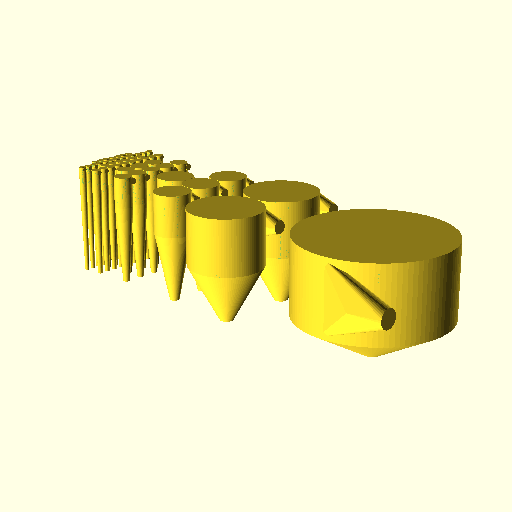

In [14]:
#POSITIONAL LEGEND:
# initParams=[intakeSlitHeight=10, intakeSlitWidth=2,
#     intakeLeft=True, vortexSearcherDepth=5, collectorDepth=75,
#     cylinderRadius=10, cylinderHeight=15, wallWidth=0.05]
init_params=[20000, 1000, 
            True, 500, 3000,
            20000, 20000, 0.5]
#reduction methods
geometric_reduction = lambda x: x/2 if x/2 > 1000 else 1000 #add floor bound
geometric_reduction_height = lambda x: x - x/4 if x - x/4 > 1000 else 1000
# geometric_reduction_intake = lambda x: x/2 if x/2 > 100 else 100
null = lambda x: x

delta_params=[geometric_reduction, geometric_reduction_height,
              null, null, null,
              geometric_reduction, geometric_reduction_height, null]

cycloneArray = cycloneArray(init_params, delta_params, 100000, 25000, 30000)
print('done', cycloneArray)
cycloneArray

In [145]:
############# Writeout Filter Model #############
scad_render_to_file(
    cycloneArray,
    "cycloneArray.scad",
)

True

In [24]:
#center point of intake:
#center point of outlet:

True

### MANIFOLD PIPELINE AND INTERFACES
- intake needs a grid for coarse grain filtering with squares of the smallest dimension (intakeSlitWidth) and exhaust needs cone with exponential slope (horn) to match radial compressor (these will be interface geometries to this module and should be designed seperately).
- also can have no manifold and seal off each row, exposing only the outlet of previous layer and inlet of next. lowest clog chance and simple. Also works with creating a box around the cyclone array. can also remove most of the intake nozzle, essentially leaving a rectangular slit as the inlet.
- consider initial cyclone with no collector cone as vortex isnt as necessary with very large mass blobs

### CONSTRAINTS 
- increase  parallel splits based on intake **cross sectional area** to keep total cross sectional area across all filters the same per sequence
- this requires manifold pipeline to allow residual 'skip' connections to the next row, in cases where a single row of the new delta_param iterated geometry doesnt fulfill cross sectional inlet/outlet equivalence. This is critical for optimal pressure differential (energy going into filtering not venturi loss).
- arrayConstraints for parametric interface: rect. prism [x,y,z]

### TODOS 
- GITHUB: set project sub-directory for cyclone filtration modules. label a README to make this discoverable through google crawlers.
- consider a hair filter or long slender blob filter as these are the worst case for this geometry of cyclone filter. should be okay with a low pressure, high volume intake zone before the cycloneArray (see drawing).
- is it okay to have negative areaBuffer in a sequence? may cause pressure to drop in this sequence, reducing airflow and therefore angular velocity therefore centripetal acceleration of particulates.

### FUTURE DEVELOPMENT
- create a radial array arrangement as well, attempt to reuse fitting optimization code from cycloneArray() for abstract geometries
